In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [3]:
def eulerAnglesToRotationMatrix(theta) :
    # Calculates Rotation Matrix given euler angles  (in radians)  
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])         
                     
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
                 
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
                     
                     
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

def calculate_new_gradient(eulerangles):
    '''
    eulerangles: e.g. array([1.57079633, 0., 0.]) (must be in radians)
    '''
    reference = [0,0,1]
    rot_matrix = eulerAnglesToRotationMatrix(eulerangles)
    return np.dot(reference, rot_matrix) #this is the new gradient!

In [4]:
# example for euler angles:
theta = np.array([60,60,30])
th=np.radians(theta)
th

array([1.04719755, 1.04719755, 0.52359878])

In [5]:
a = calculate_new_gradient(th)

In [6]:
a

array([-0.8660254,  0.4330127,  0.25     ])

In [7]:
b = np.array([0,0,1])

In [11]:
v = np.cross(a,b)
c = np.dot(a,b)
s = np.linalg.norm(v)
I = np.identity(3)
vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0)
k = np.matrix(vXStr)
r = I + k + np.matmul(k,k) * ((1 -c)/(s**2))
r

matrix([[ 0.4      ,  0.3      ,  0.8660254],
        [ 0.3      ,  0.85     , -0.4330127],
        [-0.8660254,  0.4330127,  0.25     ]])

In [20]:
#different approach:
ang = np.arccos((np.dot(a,b))/(np.dot(np.linalg.norm(a), np.linalg.norm(b))))
x = v/s
A = np.array([[0, -x[2], x[1]], 
                [x[2], 0, -x[0]], 
                [-x[1], x[0], 0]])
I = np.identity(3)

R = I+np.sin(ang)*A+(1-np.cos(ang))*A**2

R

array([[ 1.       ,  0.       ,  1.4660254],
       [ 0.       ,  1.       , -0.2830127],
       [-0.2660254,  0.5830127,  1.       ]])

In [9]:
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [22]:
res = rotationMatrixToEulerAngles(r)
res

array([1.04719755, 1.04719755, 0.64350111])

NameError: name 'old' is not defined

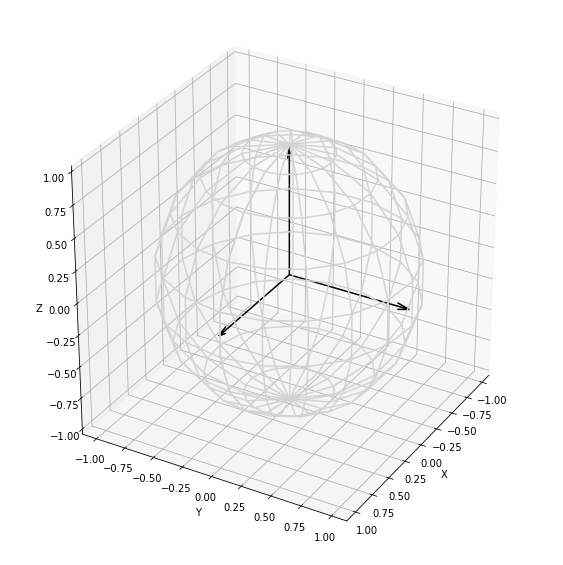

In [9]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
ax.view_init(azim=30)

# render the sphere mesh
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
#print(u,v)
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="lightgray")
plt.axis('on')

# coordinate system in centre of sphere
origin = [0,0,0]
X, Y, Z = [1,0,0], [0,1,0], [0,0,1]
O, O, O = zip(origin,origin,origin) 
X, Y, Z = zip(X,Y,Z)
ax.quiver(O,O,O,X,Y,Z, arrow_length_ratio=0.1, color = 'k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
# Plot arrows

ax.add_artist( Arrow3D([0,old[0]],[0,old[1]],[0,old[2]], mutation_scale=20, lw=1, arrowstyle="-|>", color="g")) #samples
ax.add_artist( Arrow3D([0,new[0]],[0,new[1]],[0,new[2]], mutation_scale=20, lw=1, arrowstyle="-|>", color="r")) #mean
plt.show()